## Implementing VAE on MNIST

In [84]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, hidden_dims, latent_dim):
        super(VariationalEncoder, self).__init__()

        fc_in = nn.Linear(784, hidden_dims[0])
        encoder_layers = []
        for i in range(len(hidden_dims) - 1):
            encoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(fc_in, nn.ReLU(), *encoder_layers)

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.encoder(x)
        mu =  self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [4]:
class Decoder(nn.Module):
    def __init__(self, hidden_dims, latent_dim):
        super(Decoder, self).__init__()

        fc_in = nn.Linear(latent_dim, hidden_dims[-1])
        decoder_layers = []
        for i in range(len(hidden_dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            decoder_layers.append(nn.ReLU())
        fc_out = nn.Linear(hidden_dims[0], 784)
        self.decoder = nn.Sequential(fc_in, nn.ReLU(), *decoder_layers, fc_out)
        
    def forward(self, z):
        z = self.decoder(z)
        z = torch.sigmoid(z) # use sigmoid since we treat pixcels as activated/not activated
        return z.reshape((-1, 1, 28, 28))

In [5]:
class VAE(nn.Module):
    def __init__(self, hidden_dims=[512], latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(hidden_dims, latent_dim)
        self.decoder = Decoder(hidden_dims, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [6]:
def sgvb_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    # recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # because we treat pixels as binary
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # special property for normal dist.

    return recon_loss, kl_loss

In [125]:
def train(vae, data, beta=1, verbose=True, threshold=0.1, max_epochs=10**6):
    vae.train()
    recon_history = []; kl_history = []
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(max_epochs):
        total_recon_loss = 0.0; total_kl_loss = 0.0
        for x, _ in data:    # unsupervised learning, y not used
            x = x.to(device) # GPU/CPU
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)
            
            recon_loss, kl_loss = sgvb_loss(x_hat, x, mu, logvar)
            loss = recon_loss + beta * kl_loss
            loss.backward()
            opt.step()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
        avg_recon_loss = total_recon_loss / len(data.dataset)
        avg_kl_loss = total_kl_loss / len(data.dataset)
        # record reconstruction loss and KL loss for the epoch
        recon_history.append(avg_recon_loss)
        kl_history.append(avg_kl_loss)
        if verbose:
            print('Epoch {}...\t Recon loss: {:.6f}, KL loss: {:.6f}, Total loss: {:.6f}'.format(
                epoch+1, avg_recon_loss, avg_kl_loss, avg_recon_loss+beta*avg_kl_loss))
        if epoch > 0 and recon_history[epoch-1]+beta*kl_history[epoch-1]-recon_history[epoch]-beta*kl_history[epoch] < threshold:
            break
    
    return vae, recon_history, kl_history

In [8]:
hidden_dims = [512]
latent_dim = 2
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

In [39]:
vae = VAE(hidden_dims, latent_dim).to(device) # CPU/GPU
vae, recon_history, kl_history = train(vae, data, beta=1)

Epoch 1...	 Recon loss: 180.624903, KL loss: 5.674151, Total loss: 186.299054
Epoch 2...	 Recon loss: 160.899814, KL loss: 5.367100, Total loss: 166.266914
Epoch 3...	 Recon loss: 157.304574, KL loss: 5.406292, Total loss: 162.710866
Epoch 4...	 Recon loss: 155.231628, KL loss: 5.442088, Total loss: 160.673716
Epoch 5...	 Recon loss: 153.704342, KL loss: 5.497869, Total loss: 159.202212
Epoch 6...	 Recon loss: 152.350423, KL loss: 5.572403, Total loss: 157.922826
Epoch 7...	 Recon loss: 151.349822, KL loss: 5.637190, Total loss: 156.987012
Epoch 8...	 Recon loss: 150.296300, KL loss: 5.694053, Total loss: 155.990353
Epoch 9...	 Recon loss: 149.387307, KL loss: 5.757765, Total loss: 155.145072
Epoch 10...	 Recon loss: 148.590007, KL loss: 5.796560, Total loss: 154.386567
Epoch 11...	 Recon loss: 147.911094, KL loss: 5.841132, Total loss: 153.752226
Epoch 12...	 Recon loss: 147.252705, KL loss: 5.887060, Total loss: 153.139765
Epoch 13...	 Recon loss: 146.652360, KL loss: 5.904769, Total

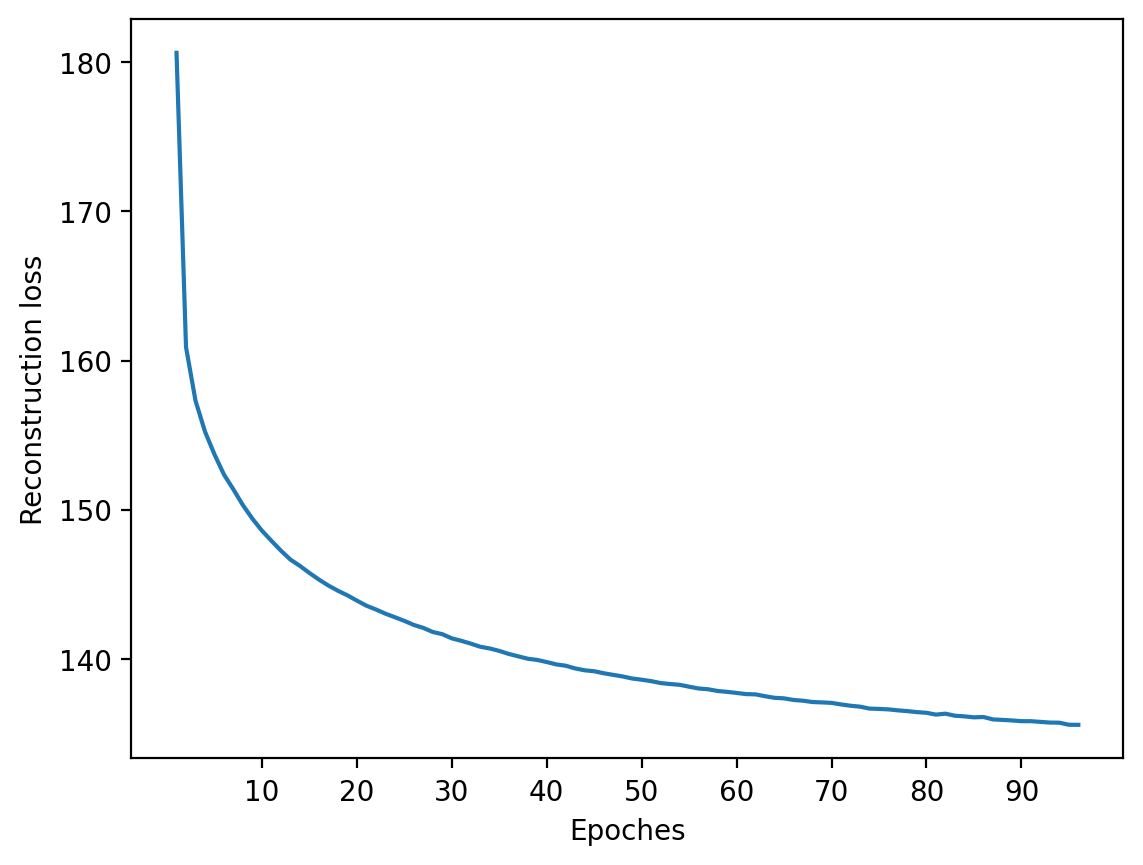

In [40]:
plt.plot(range(1,len(recon_history)+1),recon_history)
plt.xticks(list(range(10,len(recon_history)+1,10)))
plt.xlabel('Epoches')
plt.ylabel('Reconstruction loss')
plt.show()

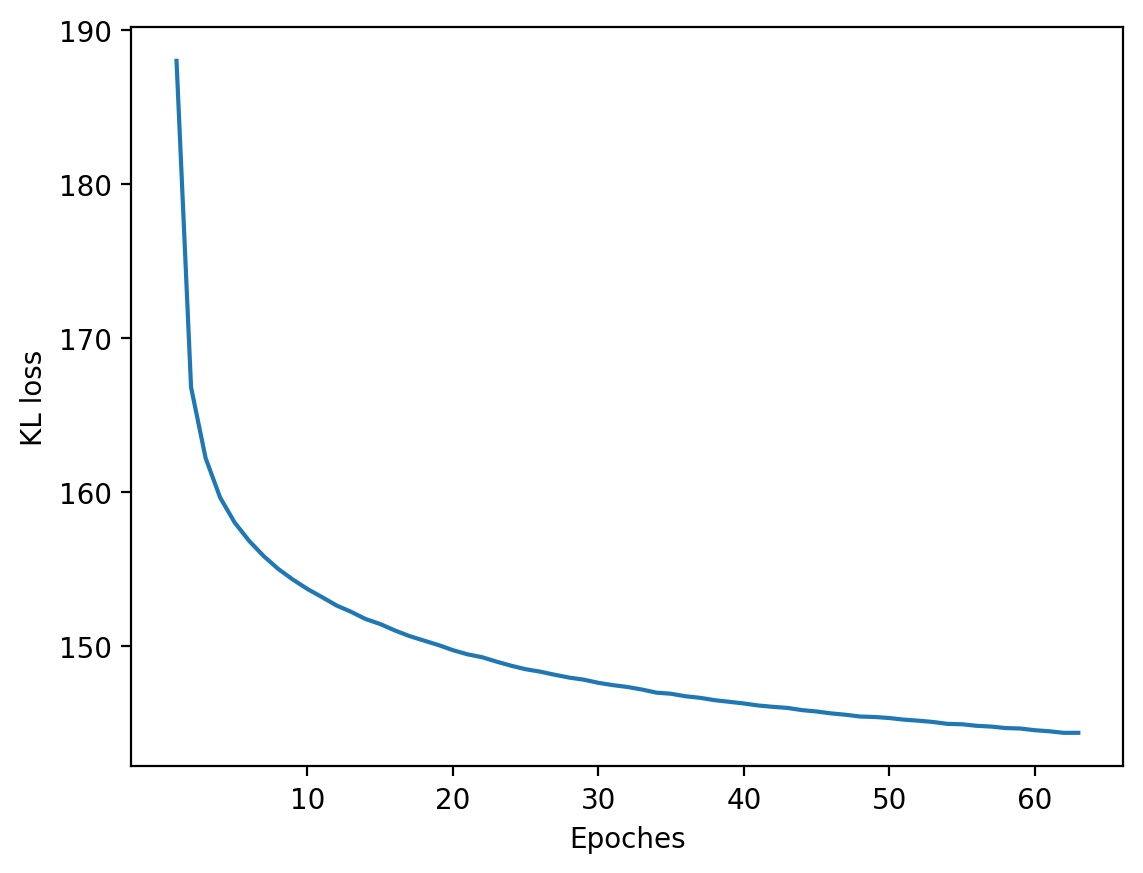

In [ ]:
plt.plot(range(1,len(kl_history)+1),kl_history)
plt.xticks(list(range(10,len(kl_history)+1,10)))
plt.xlabel('Epoches')
plt.ylabel('KL loss')
plt.show()

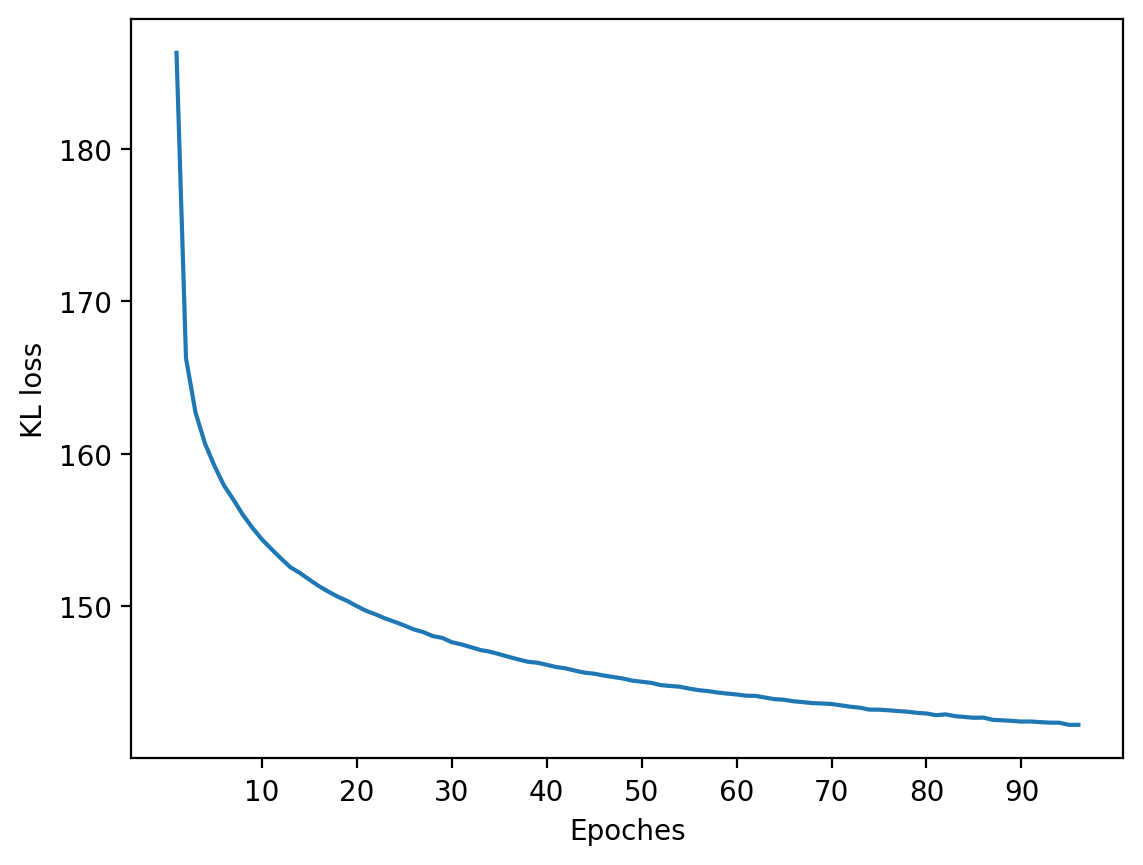

In [41]:
plt.plot(range(1,len(kl_history)+1),np.array(recon_history)+np.array(kl_history))
plt.xticks(list(range(10,len(kl_history)+1,10)))
plt.xlabel('Epoches')
plt.ylabel('KL loss')
plt.show()

In [80]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        mu, logvar = autoencoder.encoder(x.to(device))
        z = autoencoder.reparameterize(mu, logvar)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

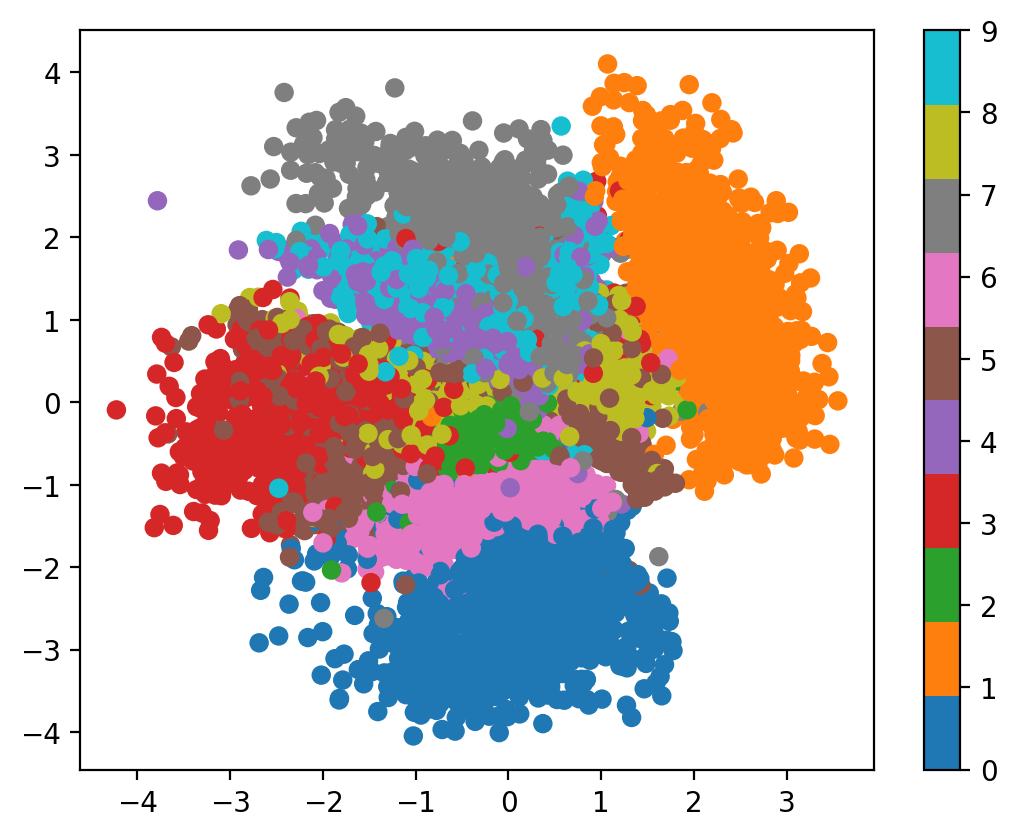

In [43]:
plot_latent(vae, data)

In [44]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

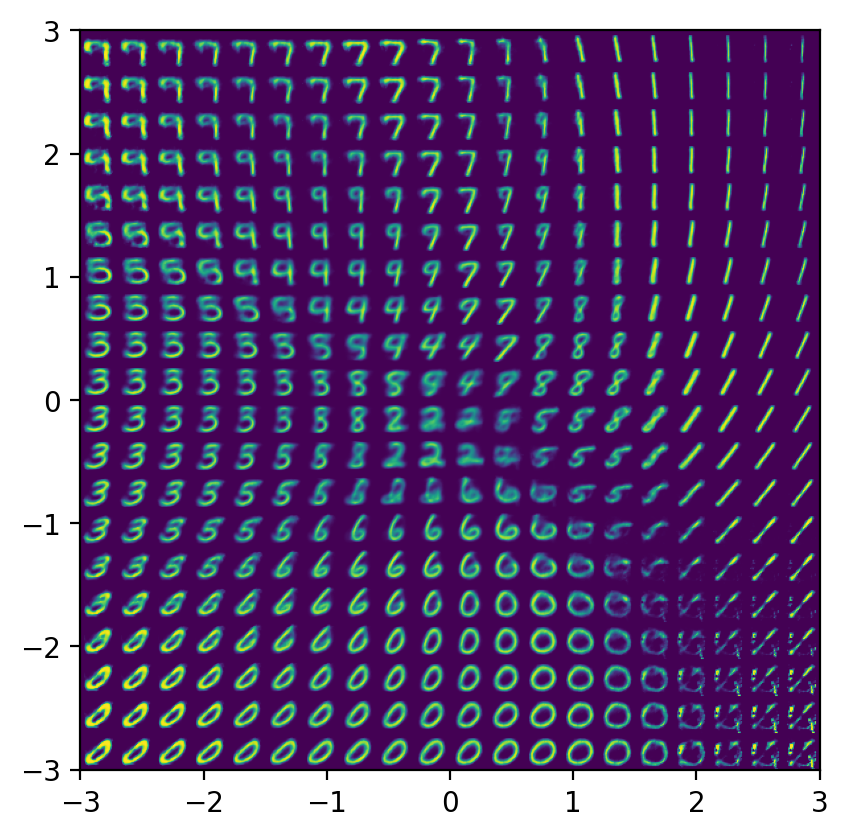

In [45]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=20)

## Finding the minimal architecture

In [9]:
def evaluate(vae, data):
    vae.eval()
    total_recon_loss = 0.0
    with torch.no_grad():
        for x, _ in data:
            x = x.to(device) # GPU/CPU
            x_hat, _, _ = vae(x)

            # Compute reconstruction loss
            # recon_loss = F.mse_loss(x_hat, x, reduction='sum')
            recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            # Accumulate total reconstruction loss
            total_recon_loss += recon_loss.item()

    # Average reconstruction loss over all samples
    avg_recon_loss = total_recon_loss / len(data.dataset)
    return avg_recon_loss

In [10]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [11]:
from itertools import combinations

# Function to check if a number is a power of 2
def is_power_of_2(num):
    return (num & (num - 1)) == 0 and num != 0

''' 
This function returns combinations of numbers that are powers of 2
The numbers will be used for number of nodes in the hidden layers
'''
def get_combs_of_pow2(start_pow=5, end_pow=10):
    # Generate powers of 2 within the specified range
    powers_of_2 = [2**i for i in range(start_pow, end_pow)]  # 32 to 512
    # Generate all combinations of powers of 2 as tuples
    tuples_result = [comb for r in range(1, len(powers_of_2)+1) for comb in combinations(powers_of_2, r) if all(is_power_of_2(num) for num in comb)]
    # Convert tuples to lists and sort each list from greatest to smallest
    lists_result = [sorted(list(tup), reverse=True) for tup in tuples_result]

    return lists_result

print(get_combs_of_pow2())

[[32], [64], [128], [256], [512], [64, 32], [128, 32], [256, 32], [512, 32], [128, 64], [256, 64], [512, 64], [256, 128], [512, 128], [512, 256], [128, 64, 32], [256, 64, 32], [512, 64, 32], [256, 128, 32], [512, 128, 32], [512, 256, 32], [256, 128, 64], [512, 128, 64], [512, 256, 64], [512, 256, 128], [256, 128, 64, 32], [512, 128, 64, 32], [512, 256, 64, 32], [512, 256, 128, 32], [512, 256, 128, 64], [512, 256, 128, 64, 32]]


In [83]:
print(get_combs_of_pow2(7,12))

[[128], [256], [512], [1024], [2048], [256, 128], [512, 128], [1024, 128], [2048, 128], [512, 256], [1024, 256], [2048, 256], [1024, 512], [2048, 512], [2048, 1024], [512, 256, 128], [1024, 256, 128], [2048, 256, 128], [1024, 512, 128], [2048, 512, 128], [2048, 1024, 128], [1024, 512, 256], [2048, 512, 256], [2048, 1024, 256], [2048, 1024, 512], [1024, 512, 256, 128], [2048, 512, 256, 128], [2048, 1024, 256, 128], [2048, 1024, 512, 128], [2048, 1024, 512, 256], [2048, 1024, 512, 256, 128]]


In [12]:
latent_dim = 3
num_param_history = []
num_epoches_history = []
test_loss_history = []
for i, test_dims in enumerate(get_combs_of_pow2()):
    print('Testing model {}...'.format(i+1))
    vae_test = VAE(test_dims, latent_dim).to(device) # CPU/GPU
    vae_test, recon_hist_test, _ = train(vae_test, data, beta=1, verbose=False)
    test_recon_loss = evaluate(vae_test, data)
    num_param_history.append(get_num_parameters(vae_test))
    num_epoches_history.append(len(recon_hist_test))
    test_loss_history.append(test_recon_loss)

Testing model 1...
Testing model 2...
Testing model 3...
Testing model 4...
Testing model 5...
Testing model 6...
Testing model 7...
Testing model 8...
Testing model 9...
Testing model 10...
Testing model 11...
Testing model 12...
Testing model 13...
Testing model 14...
Testing model 15...
Testing model 16...
Testing model 17...
Testing model 18...
Testing model 19...
Testing model 20...
Testing model 21...
Testing model 22...
Testing model 23...
Testing model 24...
Testing model 25...
Testing model 26...
Testing model 27...
Testing model 28...
Testing model 29...
Testing model 30...
Testing model 31...


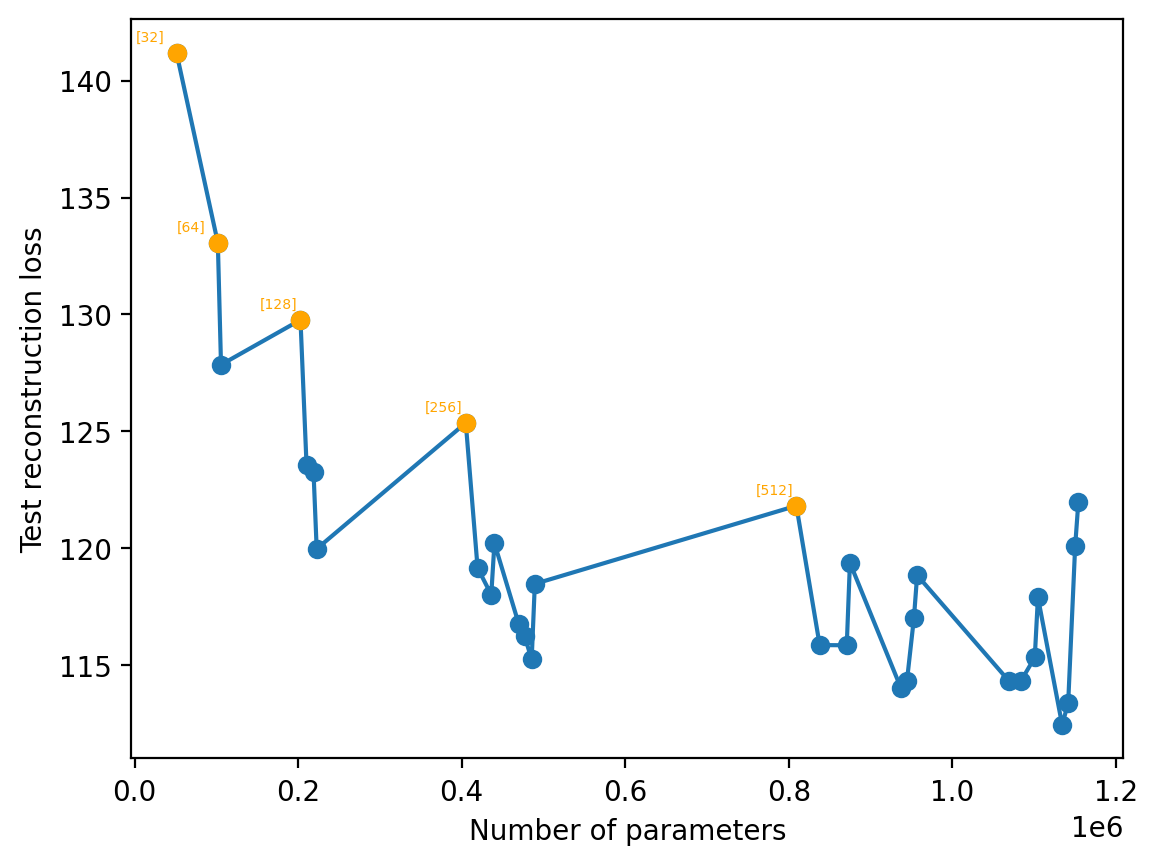

In [101]:
# Sort results by number of parameters
sorted_indices = sorted(range(len(num_param_history)), key=lambda k: num_param_history[k])
num_param_sorted = [num_param_history[i] for i in sorted_indices]
test_loss_sorted = [test_loss_history[i] for i in sorted_indices]
sorted_combs = [get_combs_of_pow2()[i] for i in sorted_indices]

plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if len(get_combs_of_pow2()[i]) == 1:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

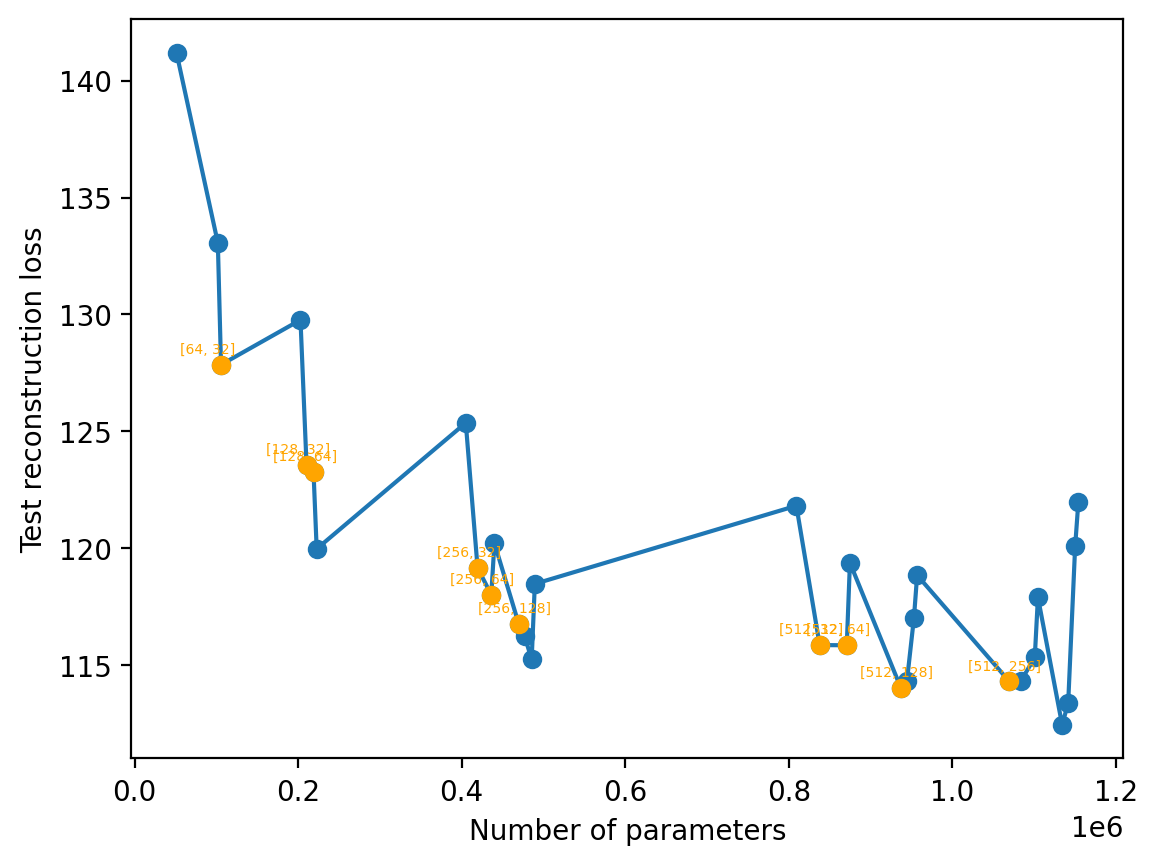

In [105]:
plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if len(get_combs_of_pow2()[i]) == 2:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

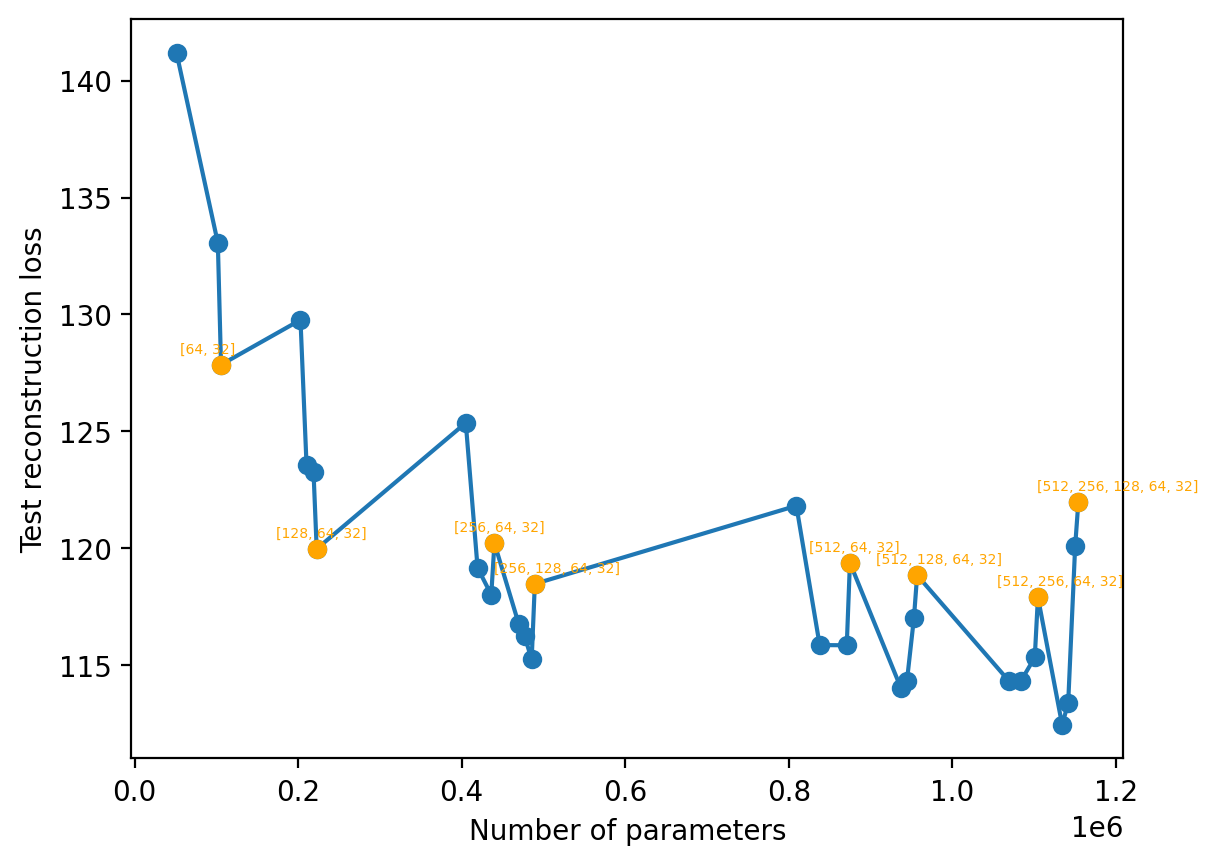

In [110]:
plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if len(get_combs_of_pow2()[i]) >1 and get_combs_of_pow2()[i][-1]==32 and get_combs_of_pow2()[i][-2]==64:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

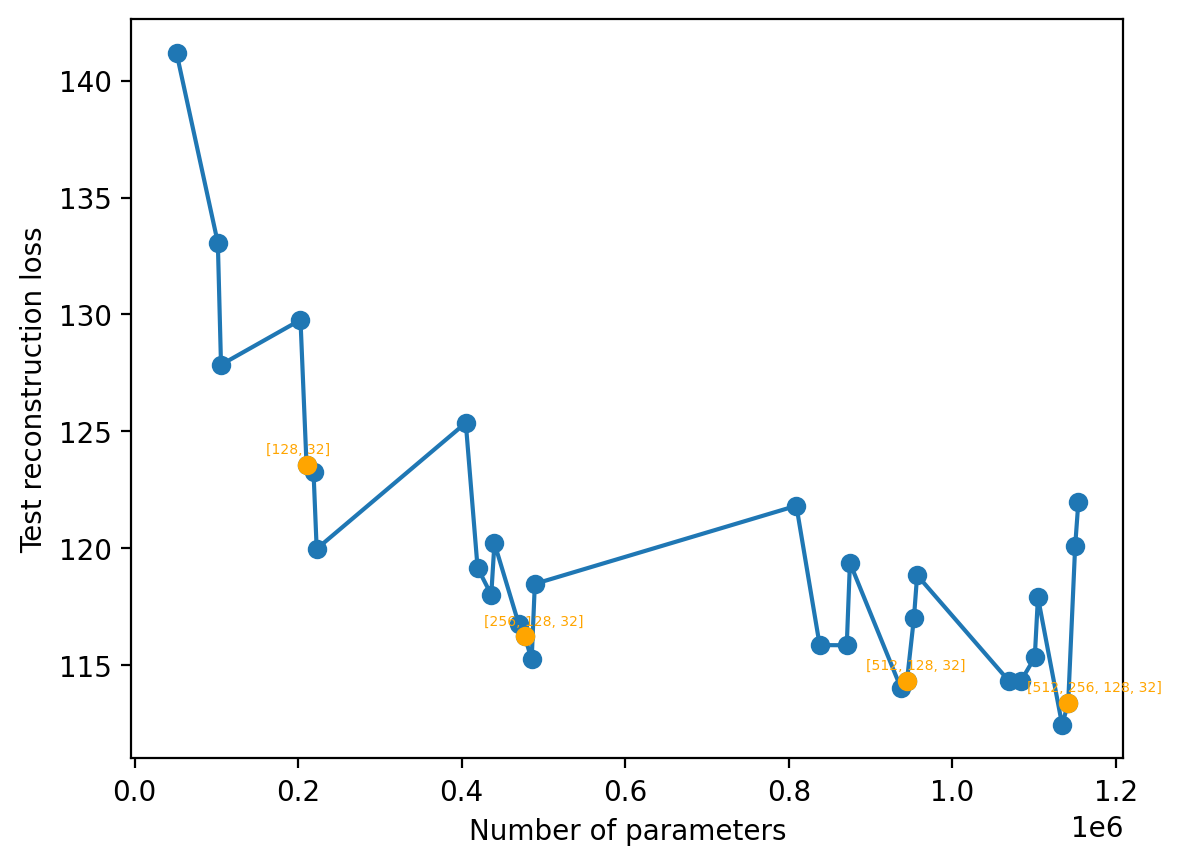

In [111]:
plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if len(get_combs_of_pow2()[i]) >1 and get_combs_of_pow2()[i][-1]==32 and get_combs_of_pow2()[i][-2]==128:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

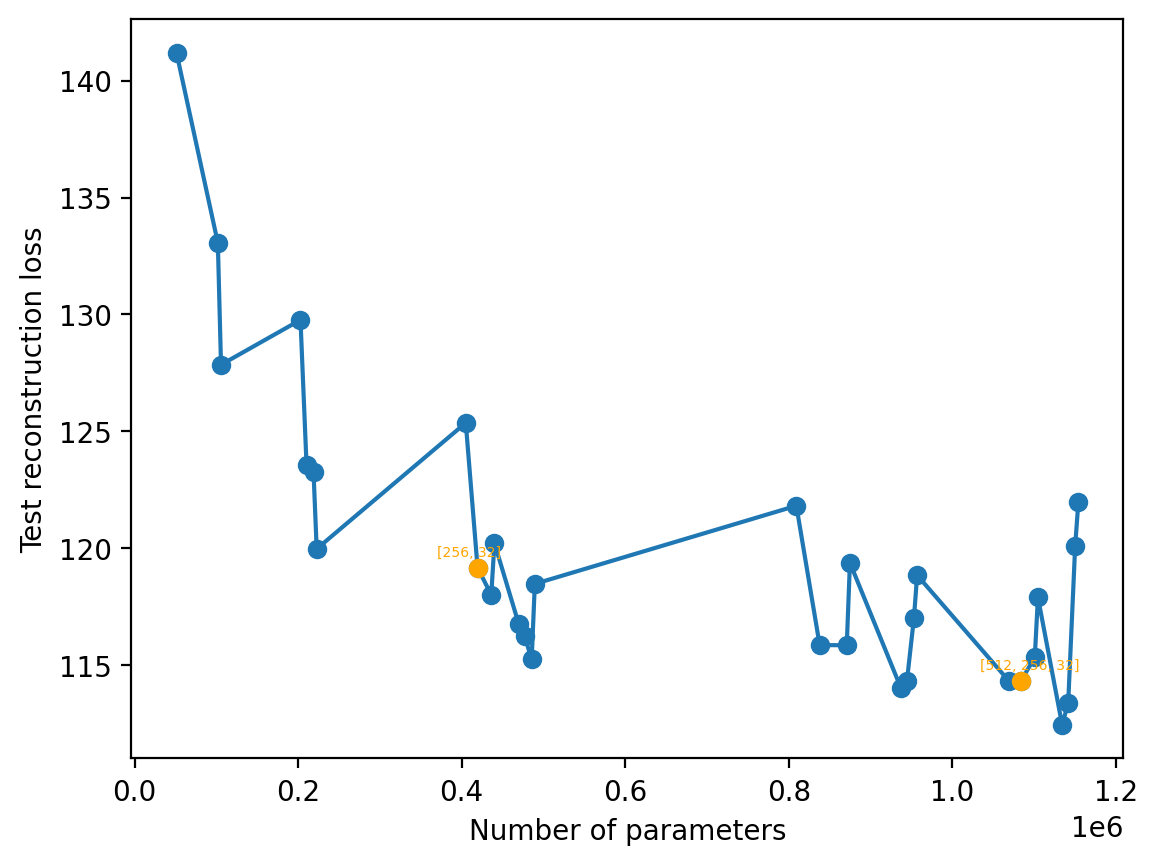

In [112]:
plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if len(get_combs_of_pow2()[i]) >1 and get_combs_of_pow2()[i][-1]==32 and get_combs_of_pow2()[i][-2]==256:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

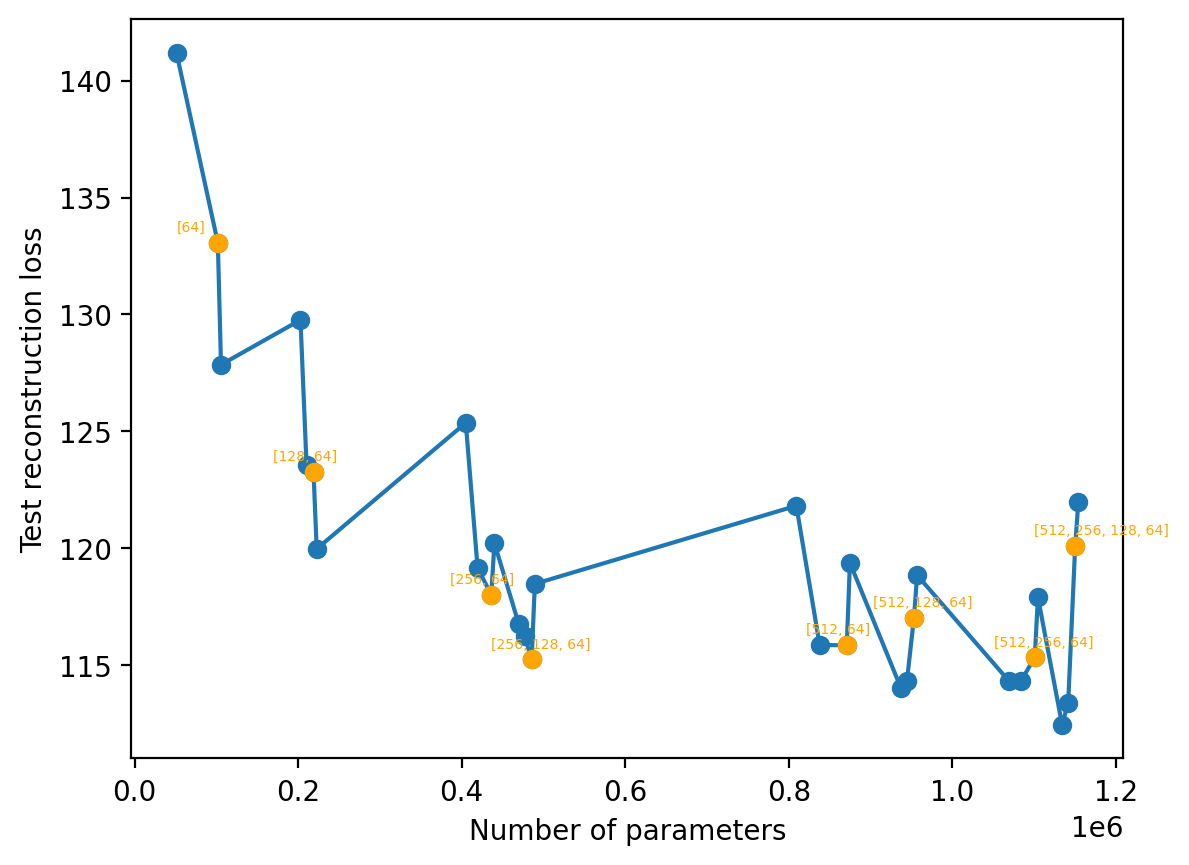

In [ ]:
plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
for i in range(len(num_param_sorted)):
    if get_combs_of_pow2()[i][-1]==64 and :
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

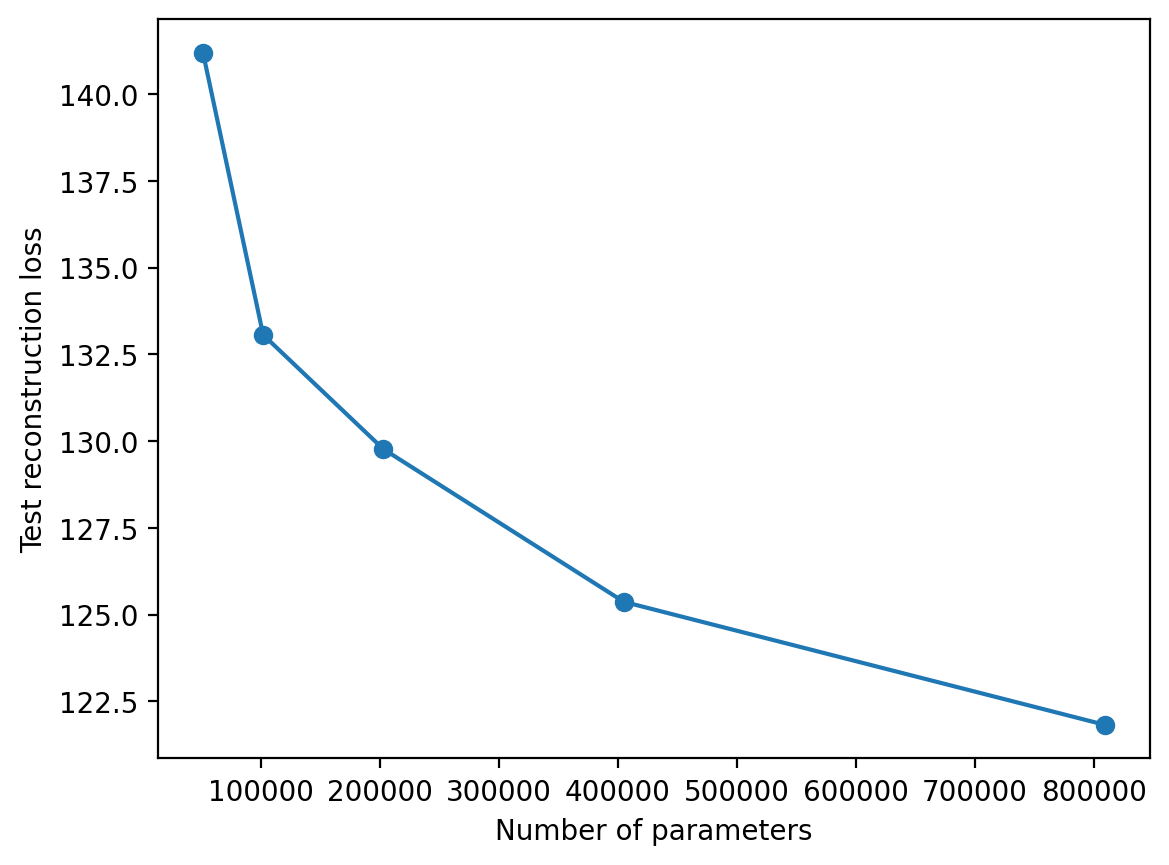

In [29]:
one_layer_ind = [i for i in range(len(sorted_combs)) if len(sorted_combs[i]) == 1]
plt.plot([num_param_sorted[i] for i in one_layer_ind], 
         [test_loss_sorted[i] for i in one_layer_ind], linestyle='-', marker='o')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

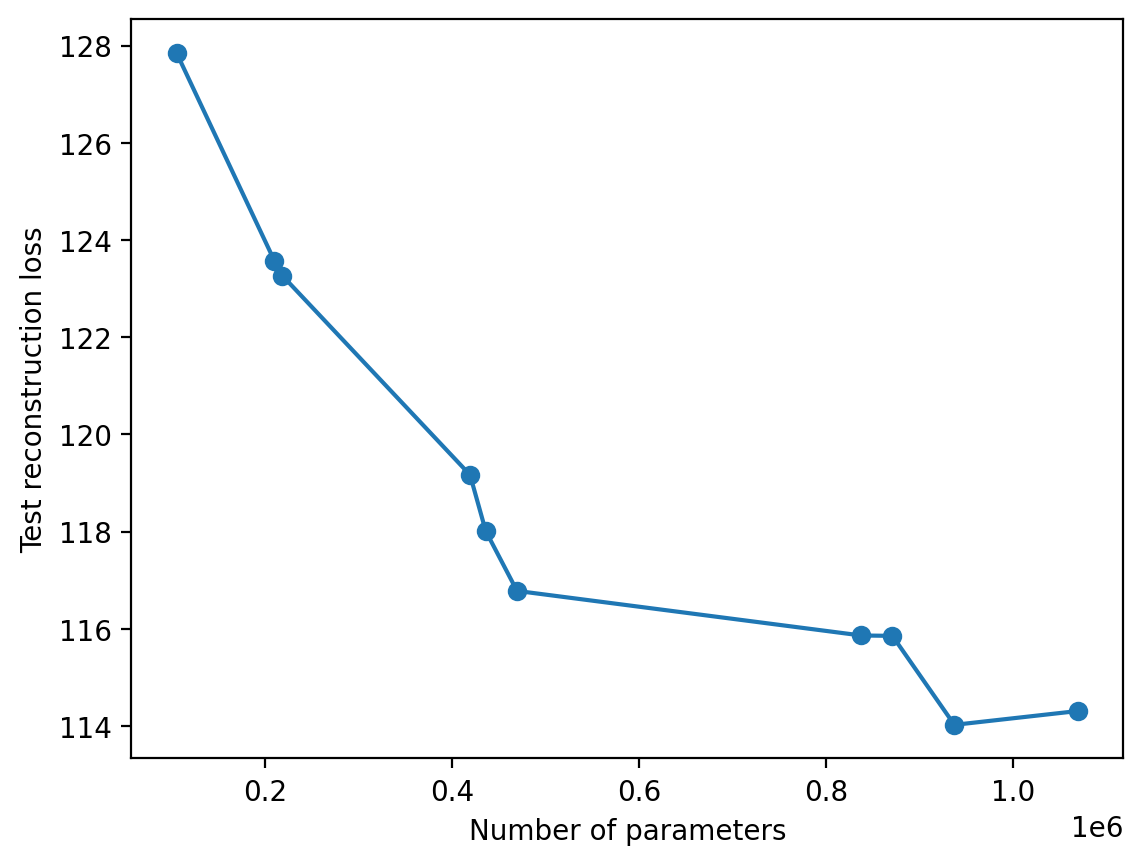

In [30]:
two_layer_ind = [i for i in range(len(sorted_combs)) if len(sorted_combs[i]) == 2]
plt.plot([num_param_sorted[i] for i in two_layer_ind], 
         [test_loss_sorted[i] for i in two_layer_ind], linestyle='-', marker='o')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

Tentative factors that affects reconstruction loss:
1. Number of layers
2. Appearence of layers with 64 and 32 nodes

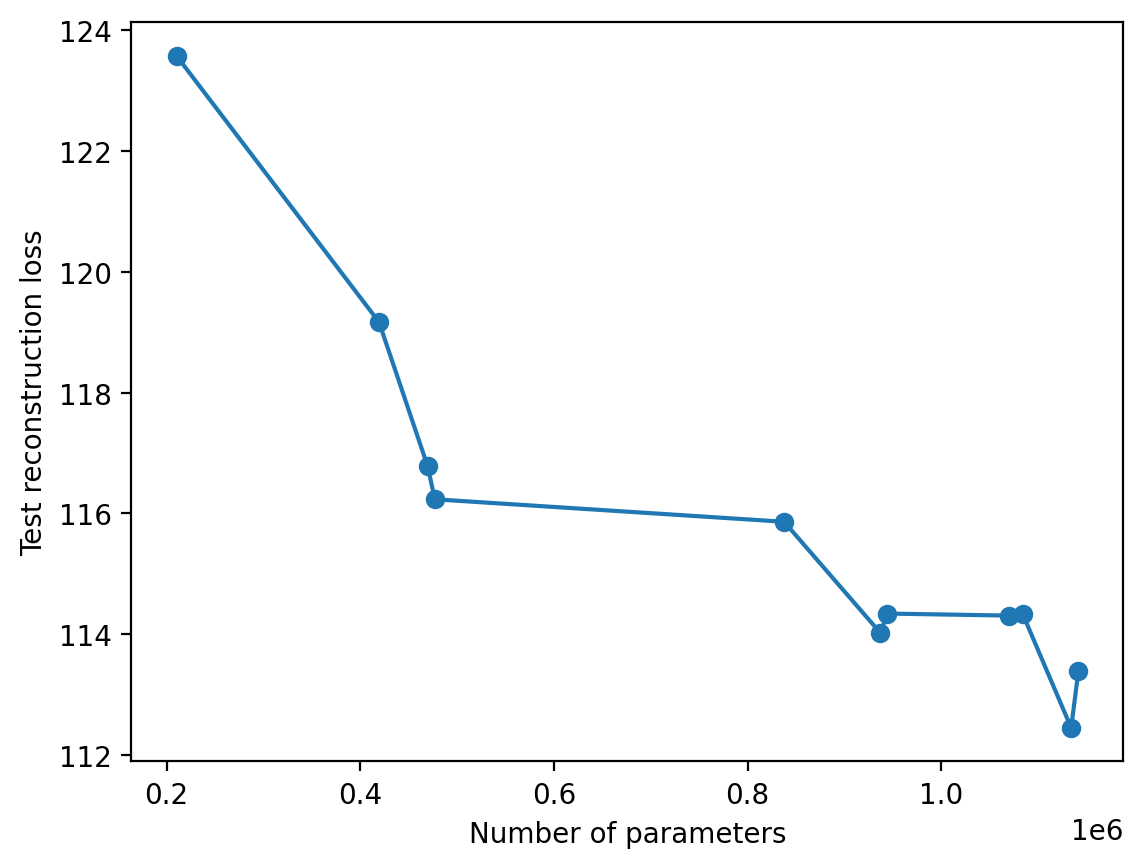

In [71]:
narrow_layer_ind = [i for i in range(len(sorted_combs)) if len(sorted_combs[i])!=1 and (64 not in sorted_combs[i] or 32 not in sorted_combs[i]) and sorted_combs[i][-1]!=64]
plt.plot([num_param_sorted[i] for i in narrow_layer_ind], 
         [test_loss_sorted[i] for i in narrow_layer_ind], linestyle='-', marker='o')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()


In [72]:
[sorted_combs[i] for i in narrow_layer_ind]

[[128, 32],
 [256, 32],
 [256, 128],
 [256, 128, 32],
 [512, 32],
 [512, 128],
 [512, 128, 32],
 [512, 256],
 [512, 256, 32],
 [512, 256, 128],
 [512, 256, 128, 32]]

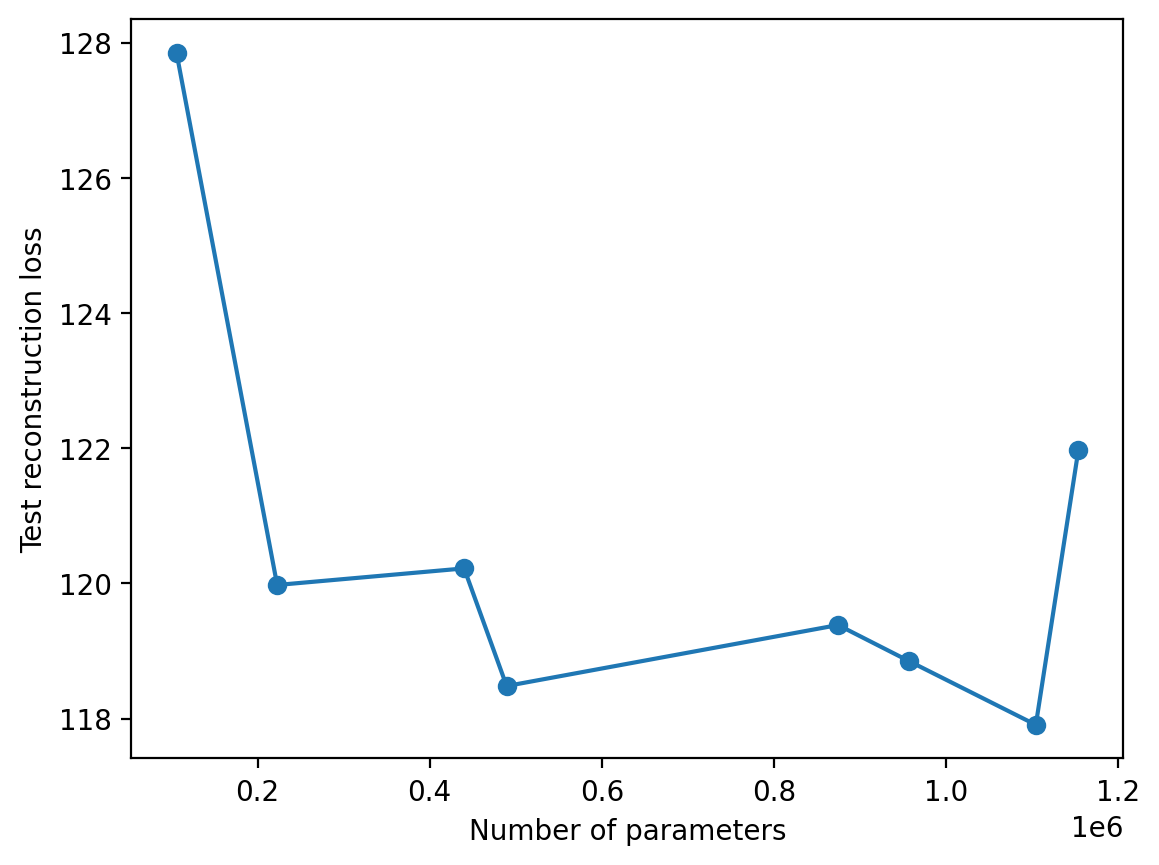

In [75]:
narrow_layer_ind = [i for i in range(len(sorted_combs)) if len(sorted_combs[i])!=1 and (64 in sorted_combs[i] and 32 in sorted_combs[i])]
plt.plot([num_param_sorted[i] for i in narrow_layer_ind], 
         [test_loss_sorted[i] for i in narrow_layer_ind], linestyle='-', marker='o')
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()


In [76]:
[sorted_combs[i] for i in narrow_layer_ind]

[[64, 32],
 [128, 64, 32],
 [256, 64, 32],
 [256, 128, 64, 32],
 [512, 64, 32],
 [512, 128, 64, 32],
 [512, 256, 64, 32],
 [512, 256, 128, 64, 32]]

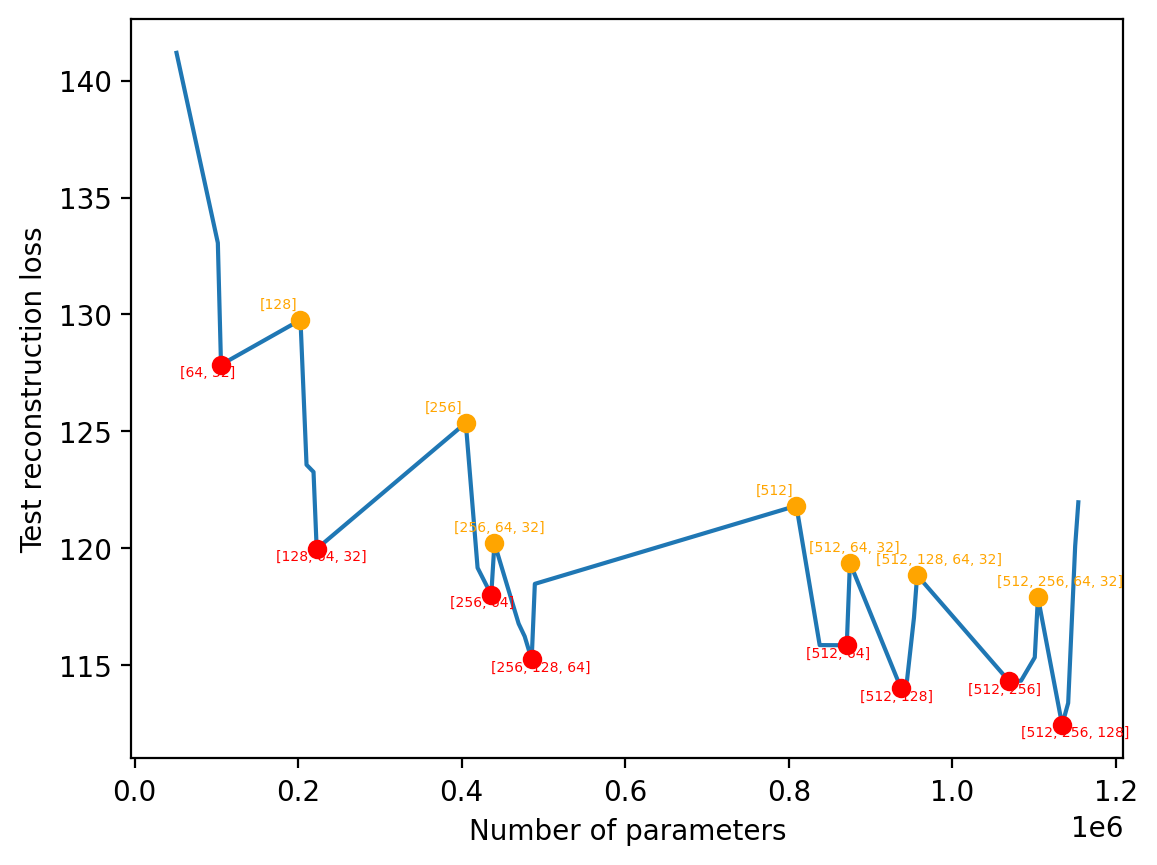

In [14]:
local_min_ind = [i for i in range(1,len(sorted_indices)-1) if 
                 test_loss_sorted[i]<test_loss_sorted[i+1] and test_loss_sorted[i]<test_loss_sorted[i-1]]
local_min_ind = [sorted_indices[i] for i in local_min_ind]
local_min_archi = [get_combs_of_pow2()[i] for i in local_min_ind]

plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', zorder=1)
for i in local_min_ind:
    plt.scatter(num_param_history[i], test_loss_history[i], color='red', zorder=2)
    plt.text(num_param_history[i]-5e4, test_loss_history[i]-0.5, get_combs_of_pow2()[i], fontsize=5, color='r')

local_max_ind = [i for i in range(1,len(sorted_indices)-1) if 
                 test_loss_sorted[i]>test_loss_sorted[i+1] and test_loss_sorted[i]>test_loss_sorted[i-1]]
local_max_ind = [sorted_indices[i] for i in local_max_ind]
local_max_archi = [get_combs_of_pow2()[i] for i in local_max_ind]

for i in local_max_ind:
    plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
    plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, get_combs_of_pow2()[i], fontsize=5, color='orange')

plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

Controling number of layers

In [141]:
latent_dim = 10
num_param_history10_2layers = []
test_loss_history10_2layers = []
train_time_history10_2layers = []

two_layer_dims = [get_combs_of_pow2(3,10)[i] for i in range(len(get_combs_of_pow2(3,10))) if len(get_combs_of_pow2(3,10)[i])==2]
for i, test_dims in enumerate(two_layer_dims):
    print('Testing model {}...'.format(i+1))
    start_time = time.time()
    vae_test = VAE(test_dims, latent_dim).to(device) # CPU/GPU
    vae_test, _, _ = train(vae_test, data, beta=1, verbose=False, threshold=0.1, max_epochs=100)
    end_time = time.time()
    test_recon_loss = evaluate(vae_test, data)
    num_param_history10_2layers.append(get_num_parameters(vae_test))
    test_loss_history10_2layers.append(test_recon_loss)
    train_time_history10_2layers.append(end_time - start_time)
    print('Time used: {} seconds'.format(end_time - start_time))

Testing model 1...
Time used: 335.2360589504242 seconds
Testing model 2...
Time used: 261.17896604537964 seconds
Testing model 3...
Time used: 313.1292669773102 seconds
Testing model 4...
Time used: 328.7144410610199 seconds
Testing model 5...
Time used: 375.9120740890503 seconds
Testing model 6...
Time used: 529.805643081665 seconds
Testing model 7...
Time used: 312.83144211769104 seconds
Testing model 8...
Time used: 285.53761100769043 seconds
Testing model 9...
Time used: 277.7561242580414 seconds
Testing model 10...
Time used: 265.78522205352783 seconds
Testing model 11...
Time used: 367.15786695480347 seconds
Testing model 12...
Time used: 267.01746702194214 seconds
Testing model 13...
Time used: 267.31098222732544 seconds
Testing model 14...
Time used: 267.77350091934204 seconds
Testing model 15...
Time used: 358.93054389953613 seconds
Testing model 16...
Time used: 241.25346183776855 seconds
Testing model 17...
Time used: 245.69753098487854 seconds
Testing model 18...
Time used:

In [137]:
latent_dim = 10
num_param_history10_3layers = []
test_loss_history10_3layers = []
train_time_history10_3layers = []

three_layer_dims = [get_combs_of_pow2(3,10)[i] for i in range(len(get_combs_of_pow2(3,10))) if len(get_combs_of_pow2(3,10)[i])==3]
for i, test_dims in enumerate(three_layer_dims):
    print('Testing model {}...'.format(i+1))
    start_time = time.time()
    vae_test = VAE(test_dims, latent_dim).to(device) # CPU/GPU
    vae_test, _, _ = train(vae_test, data, beta=1, verbose=False, threshold=10**-5, max_epochs=30)
    end_time = time.time()
    test_recon_loss = evaluate(vae_test, data)
    num_param_history10_3layers.append(get_num_parameters(vae_test))
    test_loss_history10_3layers.append(test_recon_loss)
    train_time_history10_3layers.append(end_time - start_time)
    print('Time used: {} seconds'.format(end_time - start_time))

Testing model 1...
Time used: 286.3985092639923 seconds
Testing model 2...
Time used: 294.84459805488586 seconds
Testing model 3...
Time used: 309.39417695999146 seconds
Testing model 4...
Time used: 330.30762910842896 seconds
Testing model 5...
Time used: 419.92551708221436 seconds
Testing model 6...
Time used: 85.29417896270752 seconds
Testing model 7...
Time used: 257.4061498641968 seconds
Testing model 8...
Time used: 324.37702679634094 seconds
Testing model 9...
Time used: 415.9707520008087 seconds
Testing model 10...
Time used: 269.10384917259216 seconds
Testing model 11...
Time used: 326.47972202301025 seconds
Testing model 12...
Time used: 409.97228598594666 seconds
Testing model 13...
Time used: 359.3561351299286 seconds
Testing model 14...
Time used: 303.4859211444855 seconds
Testing model 15...
Time used: 473.5120623111725 seconds
Testing model 16...
Time used: 249.0311951637268 seconds
Testing model 17...
Time used: 282.33642387390137 seconds
Testing model 18...
Time used: 

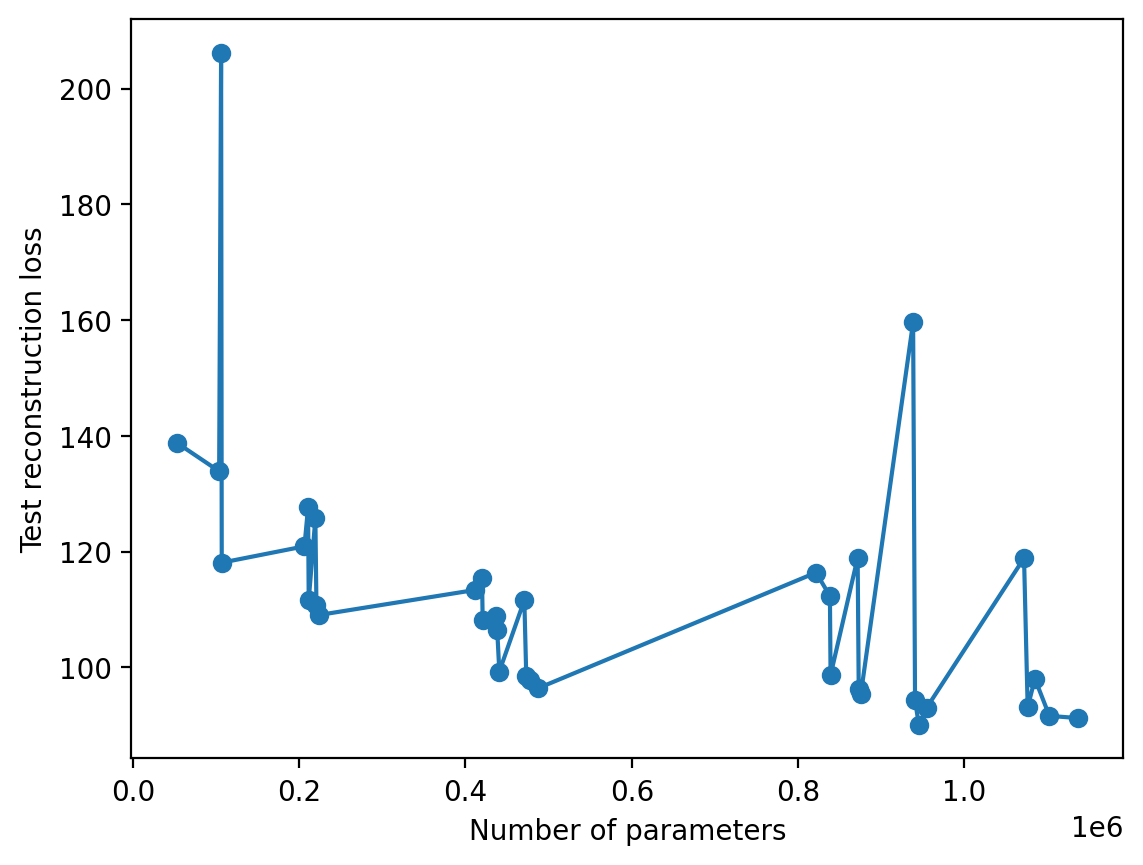

In [139]:
# Sort results by number of parameters
sorted_indices = sorted(range(len(num_param_history10_3layers)), key=lambda k: num_param_history10_3layers[k])
num_param_sorted = [num_param_history10_3layers[i] for i in sorted_indices]
test_loss_sorted = [test_loss_history10_3layers[i] for i in sorted_indices]
sorted_combs = [three_layer_dims[i] for i in sorted_indices]

plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', marker='o', zorder=1)
plt.xlabel('Number of parameters')
plt.ylabel('Test reconstruction loss')
plt.show()

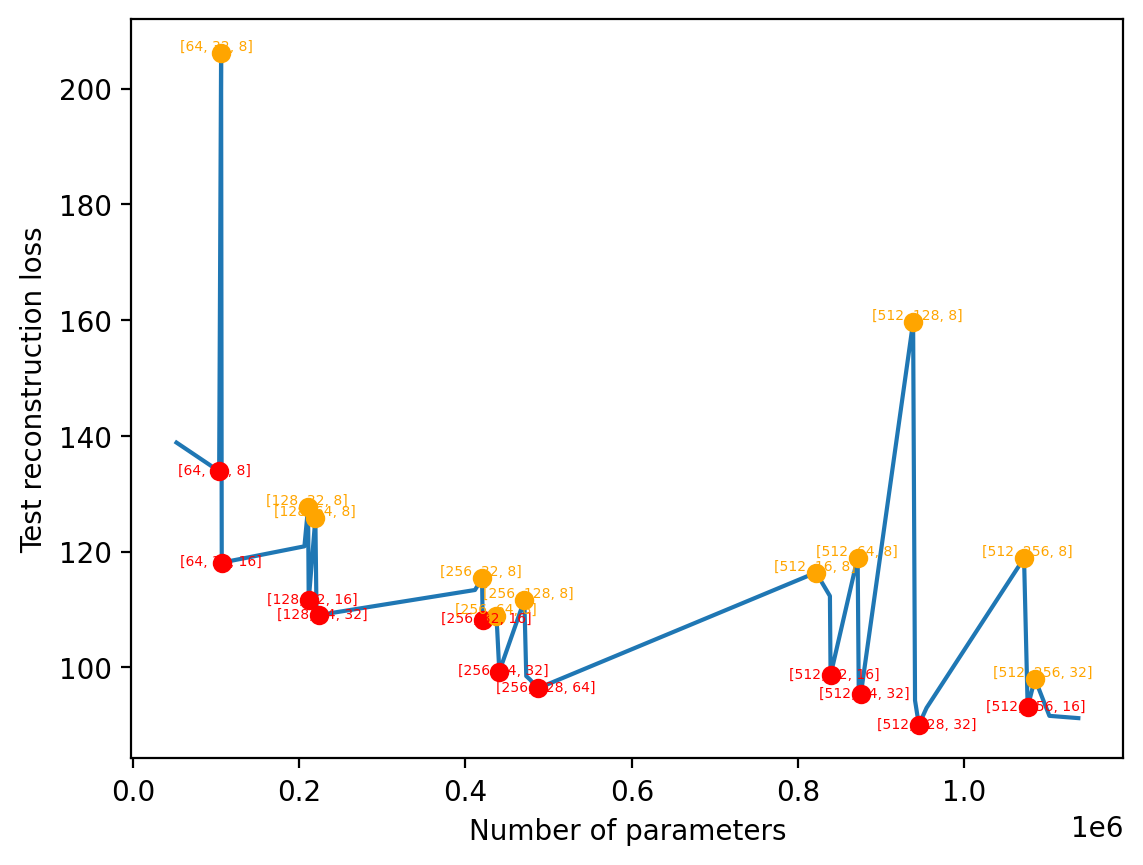

In [140]:
def draw_curve_with_extremas(num_param_history, test_loss_history, dims_list=get_combs_of_pow2()):
    # Sort results by number of parameters
    sorted_indices = sorted(range(len(num_param_history)), key=lambda k: num_param_history[k])
    num_param_sorted = [num_param_history[i] for i in sorted_indices]
    test_loss_sorted = [test_loss_history[i] for i in sorted_indices]

    local_min_ind = [i for i in range(1,len(sorted_indices)-1) if 
                     test_loss_sorted[i]<test_loss_sorted[i+1] and test_loss_sorted[i]<test_loss_sorted[i-1]]
    local_min_ind = [sorted_indices[i] for i in local_min_ind]
    # local_min_archi = [get_combs_of_pow2()[i] for i in local_min_ind]

    plt.plot(num_param_sorted, test_loss_sorted, linestyle='-', zorder=1)
    for i in local_min_ind:
        plt.scatter(num_param_history[i], test_loss_history[i], color='red', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]-0.5, dims_list[i], fontsize=5, color='r')

    local_max_ind = [i for i in range(1,len(sorted_indices)-1) if 
                     test_loss_sorted[i]>test_loss_sorted[i+1] and test_loss_sorted[i]>test_loss_sorted[i-1]]
    local_max_ind = [sorted_indices[i] for i in local_max_ind]
    # local_max_archi = [get_combs_of_pow2()[i] for i in local_max_ind]

    for i in local_max_ind:
        plt.scatter(num_param_history[i], test_loss_history[i], color='orange', zorder=2)
        plt.text(num_param_history[i]-5e4, test_loss_history[i]+0.5, dims_list[i], fontsize=5, color='orange')

    plt.xlabel('Number of parameters')
    plt.ylabel('Test reconstruction loss')
    plt.show()

draw_curve_with_extremas(num_param_history10_3layers, test_loss_history10_3layers, dims_list=three_layer_dims)

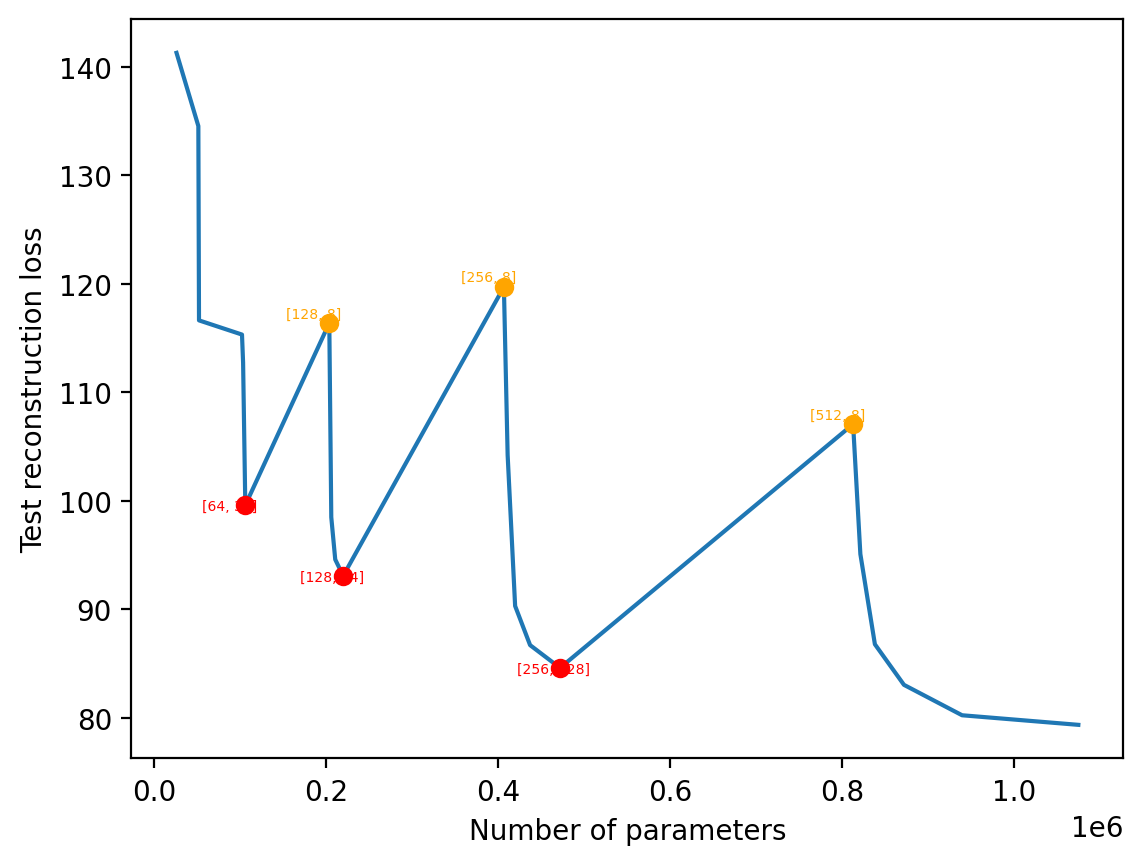

In [142]:
draw_curve_with_extremas(num_param_history10_2layers, test_loss_history10_2layers, dims_list=two_layer_dims)

## Showing some special models

In [63]:
hidden_dims = [256, 128, 64]
latent_dim = 2
vae_mini = VAE(hidden_dims, latent_dim).to(device) # CPU/GPU
vae_mini, recon_history, kl_history = train(vae_mini, data, epochs=20, beta=1)

Epoch 1...	 Recon loss: 52.020488, KL loss: 1.103156, Total loss: 53.123644
Epoch 2...	 Recon loss: 40.348244, KL loss: 3.053684, Total loss: 43.401928
Epoch 3...	 Recon loss: 36.984022, KL loss: 3.676592, Total loss: 40.660614
Epoch 4...	 Recon loss: 35.135956, KL loss: 4.052649, Total loss: 39.188605
Epoch 5...	 Recon loss: 33.942494, KL loss: 4.304563, Total loss: 38.247057
Epoch 6...	 Recon loss: 33.125414, KL loss: 4.469562, Total loss: 37.594975
Epoch 7...	 Recon loss: 32.483854, KL loss: 4.605548, Total loss: 37.089402
Epoch 8...	 Recon loss: 31.978521, KL loss: 4.706543, Total loss: 36.685064
Epoch 9...	 Recon loss: 31.600528, KL loss: 4.770079, Total loss: 36.370607
Epoch 10...	 Recon loss: 31.241030, KL loss: 4.835748, Total loss: 36.076778
Epoch 11...	 Recon loss: 30.961449, KL loss: 4.905051, Total loss: 35.866500
Epoch 12...	 Recon loss: 30.670081, KL loss: 4.957280, Total loss: 35.627361
Epoch 13...	 Recon loss: 30.433183, KL loss: 5.003459, Total loss: 35.436642
Epoch 14

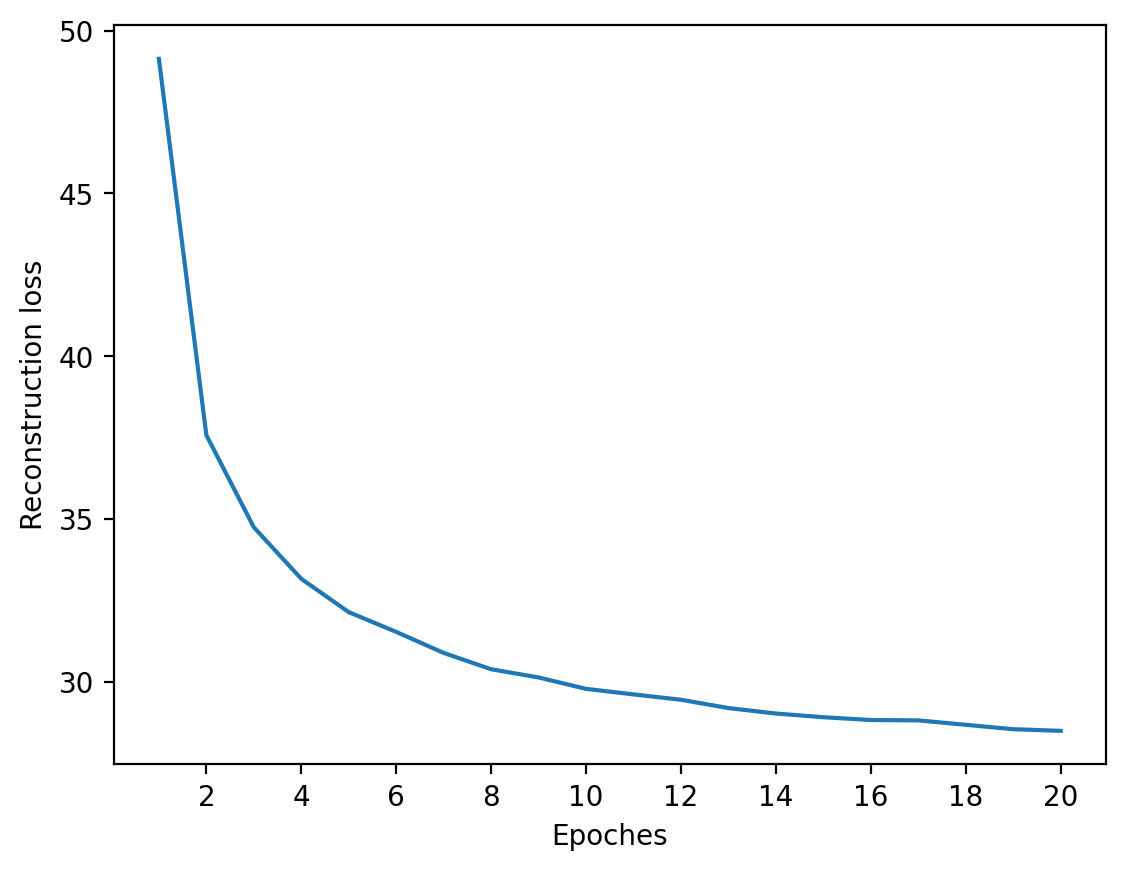

In [68]:
plt.plot(range(1,len(recon_history)+1),recon_history)
plt.xticks(list(range(2,len(recon_history)+1,2)))
plt.xlabel('Epoches')
plt.ylabel('Reconstruction loss')
plt.show()

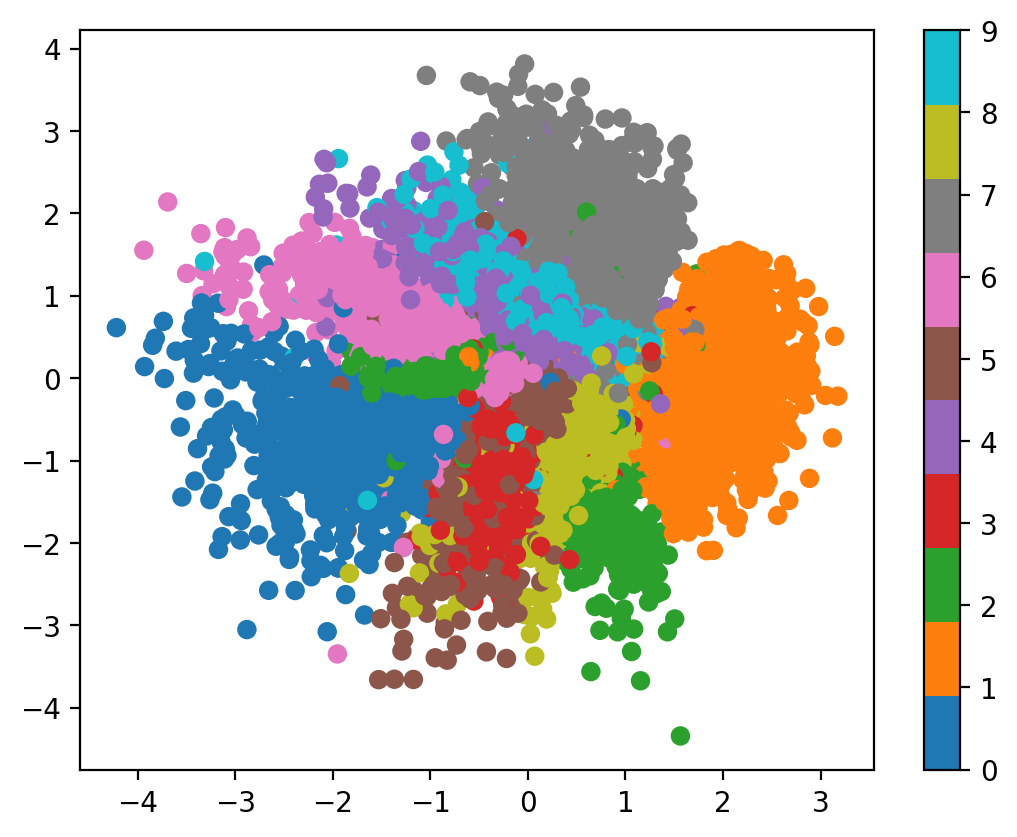

In [69]:
plot_latent(vae_mini, data)

In [75]:
evaluate(vae_mini, data)

29.144737634277345

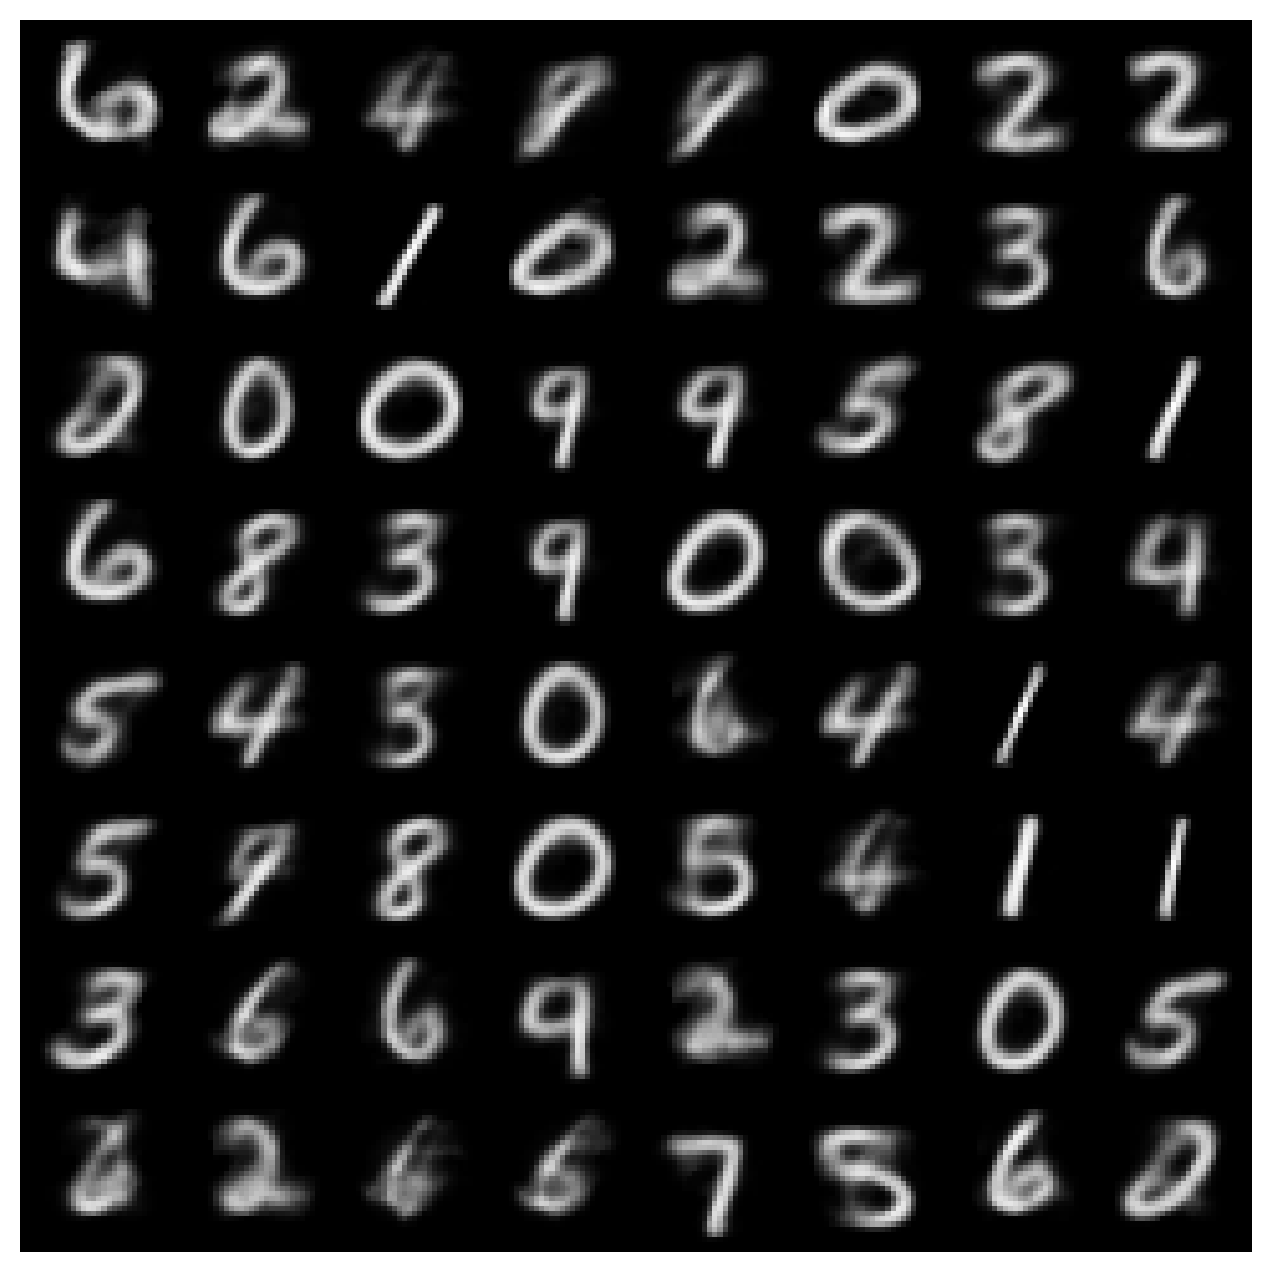

In [110]:
# Generate new images
with torch.no_grad():
    z = torch.randn(64, 2)  # latent_dim = 2
    generated_images = vae_mini.decoder(z).view(-1, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid_img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [92]:
hidden_dims = [512, 256, 64]
latent_dim = 2
vae_lowloss = VAE(hidden_dims, latent_dim).to(device) # CPU/GPU
vae_lowloss, recon_history, kl_history = train(vae_lowloss, data, epochs=20, beta=1)

Epoch 1...	 Recon loss: 48.034959, KL loss: 1.811627, Total loss: 49.846586
Epoch 2...	 Recon loss: 37.357181, KL loss: 3.636836, Total loss: 40.994017
Epoch 3...	 Recon loss: 34.435099, KL loss: 4.216831, Total loss: 38.651930
Epoch 4...	 Recon loss: 33.090414, KL loss: 4.473822, Total loss: 37.564236
Epoch 5...	 Recon loss: 32.325095, KL loss: 4.620465, Total loss: 36.945560
Epoch 6...	 Recon loss: 31.766022, KL loss: 4.744642, Total loss: 36.510664
Epoch 7...	 Recon loss: 31.165076, KL loss: 4.861191, Total loss: 36.026267
Epoch 8...	 Recon loss: 30.670104, KL loss: 4.971513, Total loss: 35.641617
Epoch 9...	 Recon loss: 30.258729, KL loss: 5.043604, Total loss: 35.302333
Epoch 10...	 Recon loss: 30.045234, KL loss: 5.110675, Total loss: 35.155909
Epoch 11...	 Recon loss: 29.759137, KL loss: 5.156550, Total loss: 34.915686
Epoch 12...	 Recon loss: 29.608116, KL loss: 5.190921, Total loss: 34.799037
Epoch 13...	 Recon loss: 29.340193, KL loss: 5.236808, Total loss: 34.577001
Epoch 14

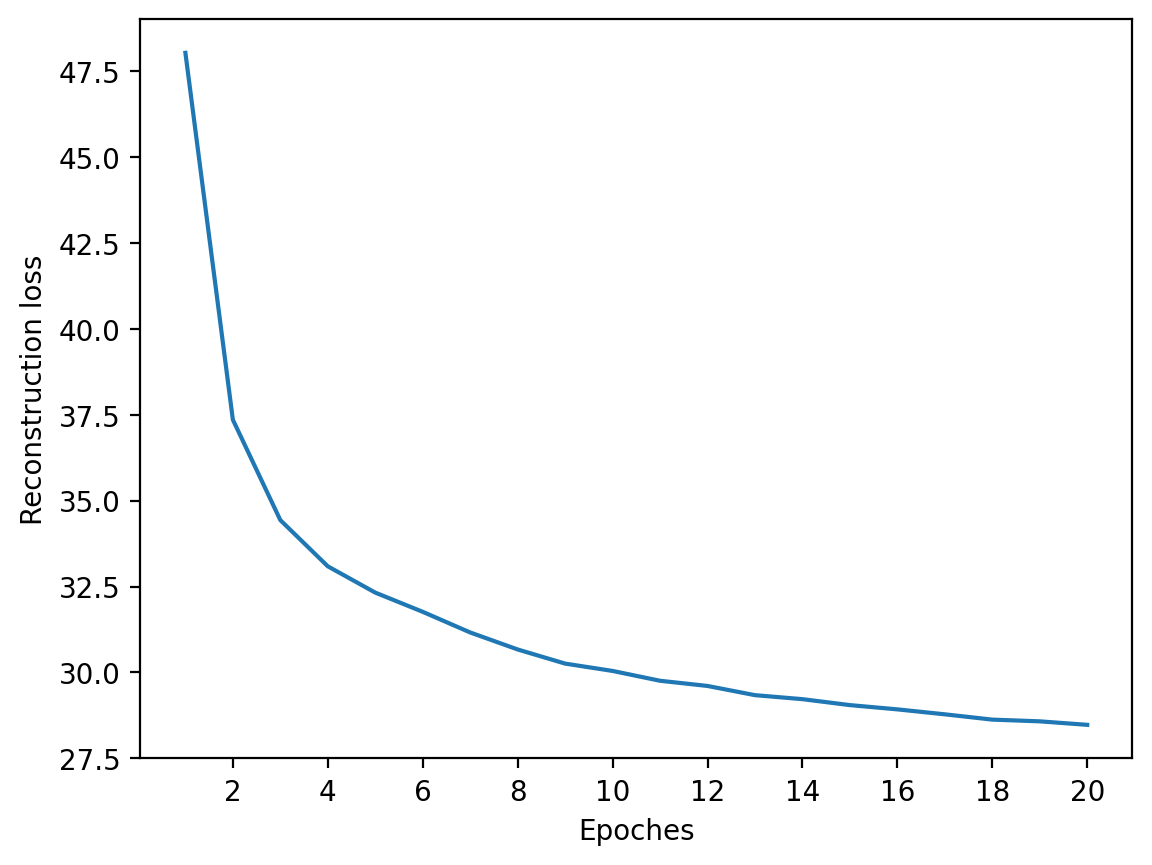

In [93]:
plt.plot(range(1,len(recon_history)+1),recon_history)
plt.xticks(list(range(2,len(recon_history)+1,2)))
plt.xlabel('Epoches')
plt.ylabel('Reconstruction loss')
plt.show()

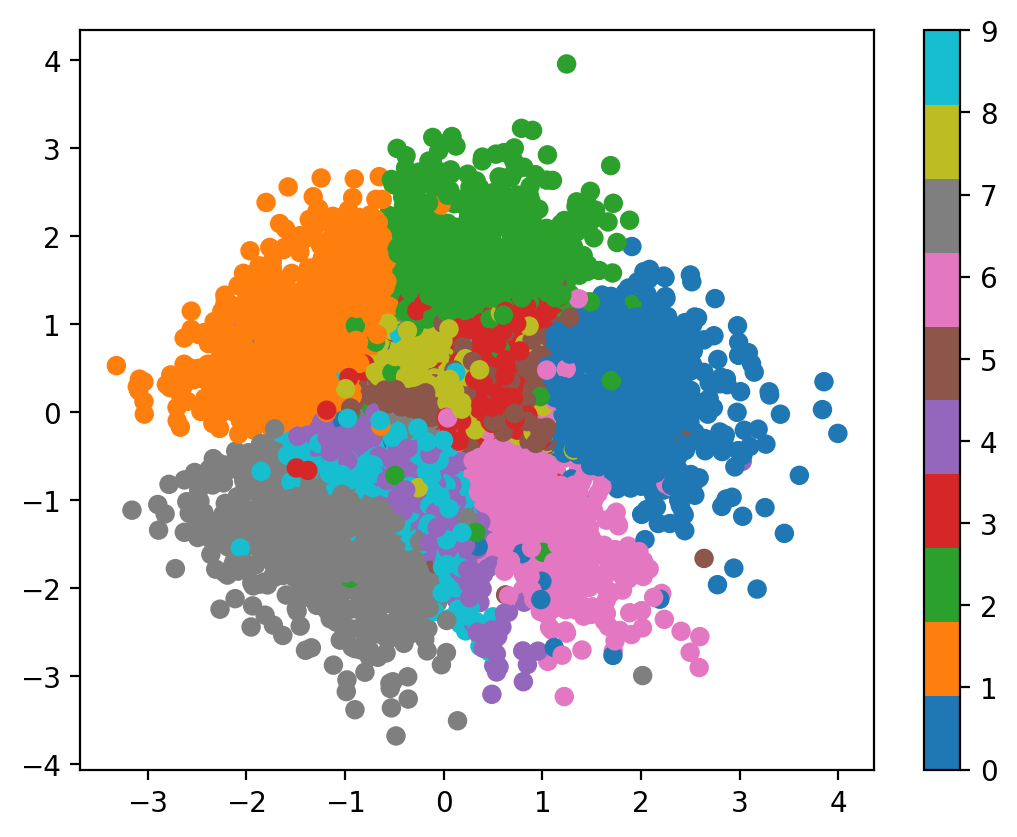

In [94]:
plot_latent(vae_lowloss, data)

In [95]:
evaluate(vae_lowloss, data)

28.808729463704427

In [77]:
hidden_dims = [512, 256, 128, 64, 32]
latent_dim = 2
vae_large = VAE(hidden_dims, latent_dim).to(device) # CPU/GPU
vae_large, recon_history, kl_history = train(vae_large, data, beta=1)

Epoch 1...	 Recon loss: 200.921359, KL loss: 1.781320, Total loss: 202.702679
Epoch 2...	 Recon loss: 168.437078, KL loss: 4.063024, Total loss: 172.500101
Epoch 3...	 Recon loss: 151.921920, KL loss: 5.357748, Total loss: 157.279668
Epoch 4...	 Recon loss: 146.165563, KL loss: 5.784214, Total loss: 151.949777
Epoch 5...	 Recon loss: 142.593640, KL loss: 6.044884, Total loss: 148.638524
Epoch 6...	 Recon loss: 140.159592, KL loss: 6.187478, Total loss: 146.347070
Epoch 7...	 Recon loss: 138.462865, KL loss: 6.322652, Total loss: 144.785516
Epoch 8...	 Recon loss: 137.093469, KL loss: 6.408362, Total loss: 143.501831
Epoch 9...	 Recon loss: 136.215328, KL loss: 6.456504, Total loss: 142.671832
Epoch 10...	 Recon loss: 135.036764, KL loss: 6.526147, Total loss: 141.562911
Epoch 11...	 Recon loss: 134.789691, KL loss: 6.563455, Total loss: 141.353146
Epoch 12...	 Recon loss: 134.950202, KL loss: 6.584858, Total loss: 141.535060
Epoch 13...	 Recon loss: 133.967447, KL loss: 6.644958, Total

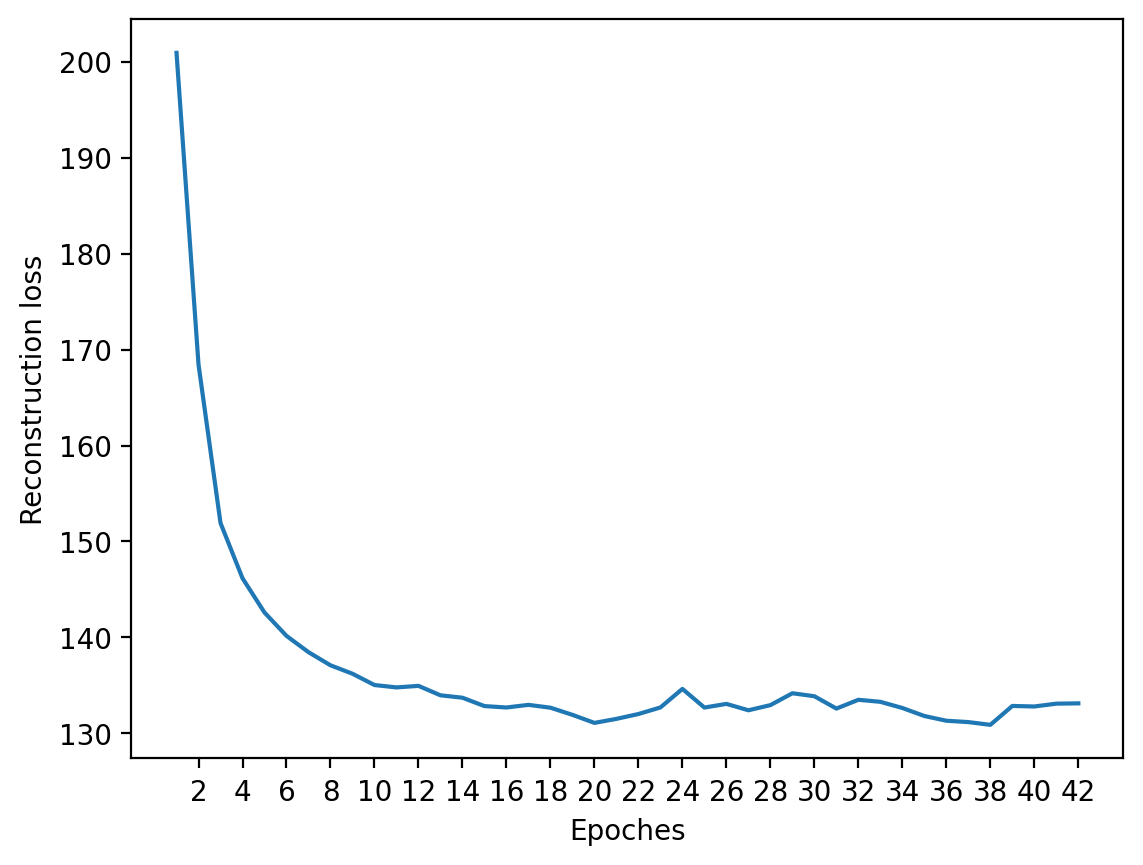

In [78]:
plt.plot(range(1,len(recon_history)+1),recon_history)
plt.xticks(list(range(2,len(recon_history)+1,2)))
plt.xlabel('Epoches')
plt.ylabel('Reconstruction loss')
plt.show()

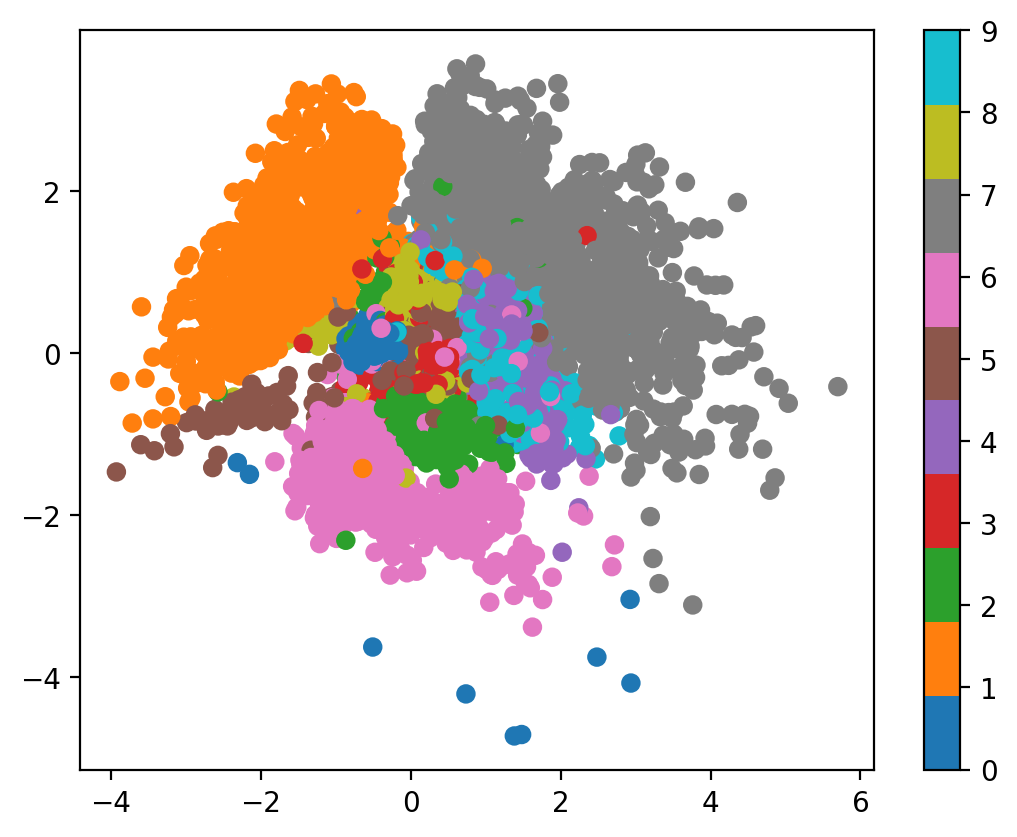

In [81]:
plot_latent(vae_large, data)

In [99]:
evaluate(vae_large, data)

36.54411881917318

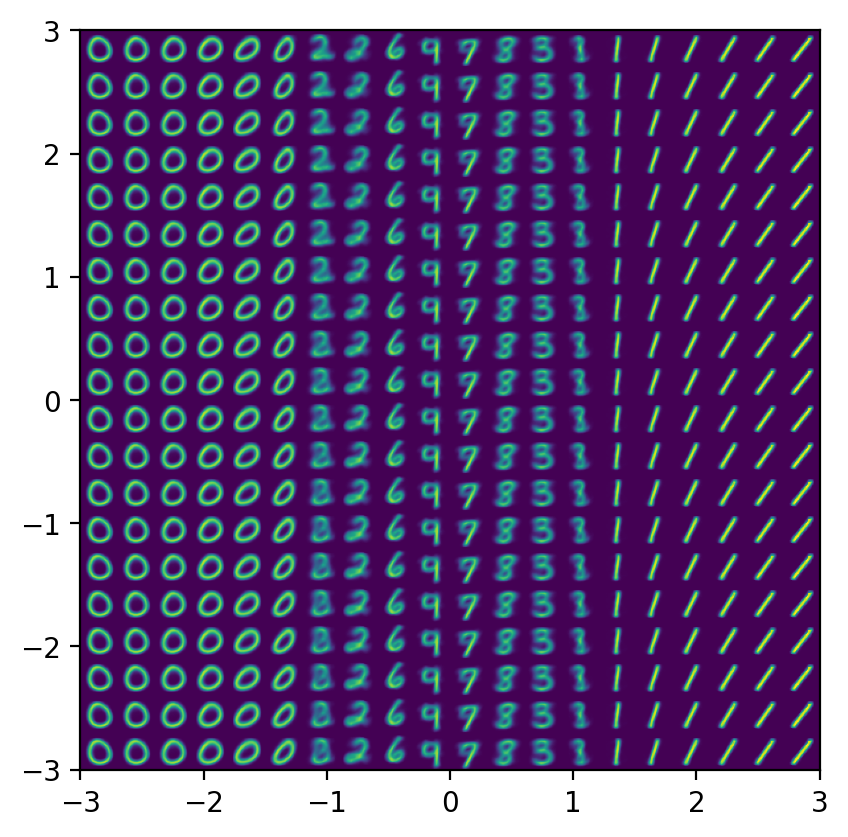

In [102]:
plot_reconstructed(vae_large, r0=(-3, 3), r1=(-3, 3), n=20)